In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'news-summary:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1895%2F791838%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240412%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240412T055137Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D45b7e7ba18b9a1a2c851c4fa7c3f9668d4d738e56a8bb2b78795aeeb8eebe8986aa4308329c92a5811509474b8f2ce87dde2d4da752a130873960a246e8ca6e4ae3a6f5ec7ab676dbe82b24f0b0fe1282b8dfc33827d0d4cbb456f6d65abc34fb05f1a995988915f971d6ad092d07453b457ce89daac5c34f4ab69f00b5dba7fbf5e0979f62cbc4433c6753c4d90e63a4f9e5c201eb64c486249d1c9e03129d9dadb2ea49c8b5d2919b63ecbffc9376ddf845340f50c6c93f9dc7e2772a5a8bb68c46fc117cf2ba11f6106d6757d01adaaa89dbff9a5e828f96a17b05c84b7fa7cae8228393d143981807ed44526ce0a42f4d3f2d56f9da25d858589e9dd478c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 20718321 bytes downloaded
Downloaded and uncompressed: news-summary
Data source import complete.


# Abstractive Text Summarization

[Post](https://towardsdatascience.com/data-scientists-guide-to-summarization-fc0db952e363) on getting started with `text summarization`, their pros and cons and much more.

**There 3 different training models used here**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.
- `build_hybrid_seq2seq_model` - **Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

**To see the full learning and results of all the 3 model go to the end of the notebook in the `Running all the 3 different models` section**

The `model (the trained model)`, `encoder_model (for inference)` and `decoder_model (for inference)` for **Seq2Seq with just LSTMs** are only saved.

![](https://media.giphy.com/media/dsKnRuALlWsZG/giphy.gif)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

In [ ]:
!pip install -q contractions==0.0.48

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 4.2 MB/s eta 0:00:00


In [ ]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [ ]:
# # Using TPU

# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

## 🪂 Getting the data

In [ ]:
# filename1 = '../input/news-summary/news_summary.csv'
# filename2 = '../input/news-summary/news_summary_more.csv'

# df1 = pd.read_csv(filename1, encoding='iso-8859-1').reset_index(drop=True)
# df2 = pd.read_csv(filename2, encoding='iso-8859-1').reset_index(drop=True)

In [ ]:
# df1.head()

In [ ]:
amazon_df=pd.read_csv("/content/drive/MyDrive/Reviews.csv")[0:10000]

In [ ]:
# Keep only the 'Summary' and 'Text' columns
amazon_df = amazon_df[['Summary', 'Text']]

# Rename the columns to 'headlines' and 'text'
amazon_df.rename(columns={'Summary': 'headlines', 'Text': 'text'}, inplace=True)

# Display the first few rows to verify the changes

<ipython-input-15-894f1abc87da>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_df.rename(columns={'Summary': 'headlines', 'Text': 'text'}, inplace=True)


In [ ]:
amazon_df['text'].size

10000

In [ ]:
# df2

In [ ]:
# df1_columns = df1.columns.tolist()
# df1_columns.remove('headlines')
# df1_columns.remove('text')
# df1.drop(df1_columns, axis='columns', inplace=True)

# df = pd.concat([df1, df2], axis='rows')
# del df1, df2

# # Shuffling the df
# df = df.sample(frac=1).reset_index(drop=True)

# print(f'Dataset size: {len(df)}')
# df.sample(5)

The `headlines` column will be treated as `summary` for the text.

In [ ]:
df=amazon_df

In [ ]:
# df.head()

## 🏂 Data preparation

In [ ]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


expand_contractions("y'all can't expand contractions i'd think")

'you all can not expand contractions id think'

In [ ]:
# Converting to lowercase
# df.text = df.text.apply(str.lower)
# df.headlines = df.headlines.apply(str.lower)

# df.sample(5)


# Convert NaNs to empty strings in the 'headlines' column
amazon_df['headlines'] = amazon_df['headlines'].fillna('')

# Converting to lowercase
amazon_df['text'] = amazon_df['text'].str.lower()
amazon_df['headlines'] = amazon_df['headlines'].str.lower()



In [ ]:
df.headlines = df.headlines.apply(expand_contractions)
df.text = df.text.apply(expand_contractions)
df.sample(5)

,headlines,text
4112,windows 7 usb issue!,ill add to the growing list of reviews here re...
3577,pink perfection!,when i stumbled across pink grapefruit tic tac...
6733,kind of taste like a cheap champagne!!!,this is for sure not what i was expecting it t...
7833,awful taste! do not buy it!!,i bought this tea cause i had consumed the one...
3150,if you like gummy white bread . . . .,"white bread is not my thing, so that is probab..."


In [ ]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word('#cool!'))


# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [ ]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


In [ ]:
# import nltk
# from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

rm_stopwords_from_text("Love means never having to say you're sorry")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'Love means never say sorry'

In [ ]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [ ]:
df.text = df.text.apply(clean_text)
df.headlines = df.headlines.apply(clean_text)
df.sample(5)

,headlines,text
8884,aff,smooth rewarding ff bite taste buds simply enj...
5085,tasty,great sauce used many jamaican restaurants hel...
3530,great tea,arrived nicely packaged sealed aromatic lovely...
299,best energy shot ever tasted,first found steaz berry energy shots local org...
4634,mushy english muffins,energ foods english muffins look good packagin...


In [ ]:
# import os

# # Check if the file exists
# file_path = '/content/drive/MyDrive/cleaned_data.csv'
# if os.path.exists(file_path):
#     # Load the cleaned data from the CSV file into the DataFrame
#     df = pd.read_csv(file_path)
#     print("Cleaned data loaded successfully.")
# else:
#     # Perform data cleaning process here
#     # For example:
#     # df = perform_data_cleaning()
#     print("No cleaned data file found. Performing data cleaning...")

#     # Once data cleaning is done, save the cleaned data to CSV
    # df.to_csv('/content/drive/MyDrive/cleaned_data.csv')


In [ ]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)

    # Adding words to stopwords
    # these words showed up while plotting wordcloud for text
    wc_stopwords.add('s')
    wc_stopwords.add('one')
    wc_stopwords.add('using')
    wc_stopwords.add('example')
    wc_stopwords.add('work')
    wc_stopwords.add('use')
    wc_stopwords.add('make')

    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

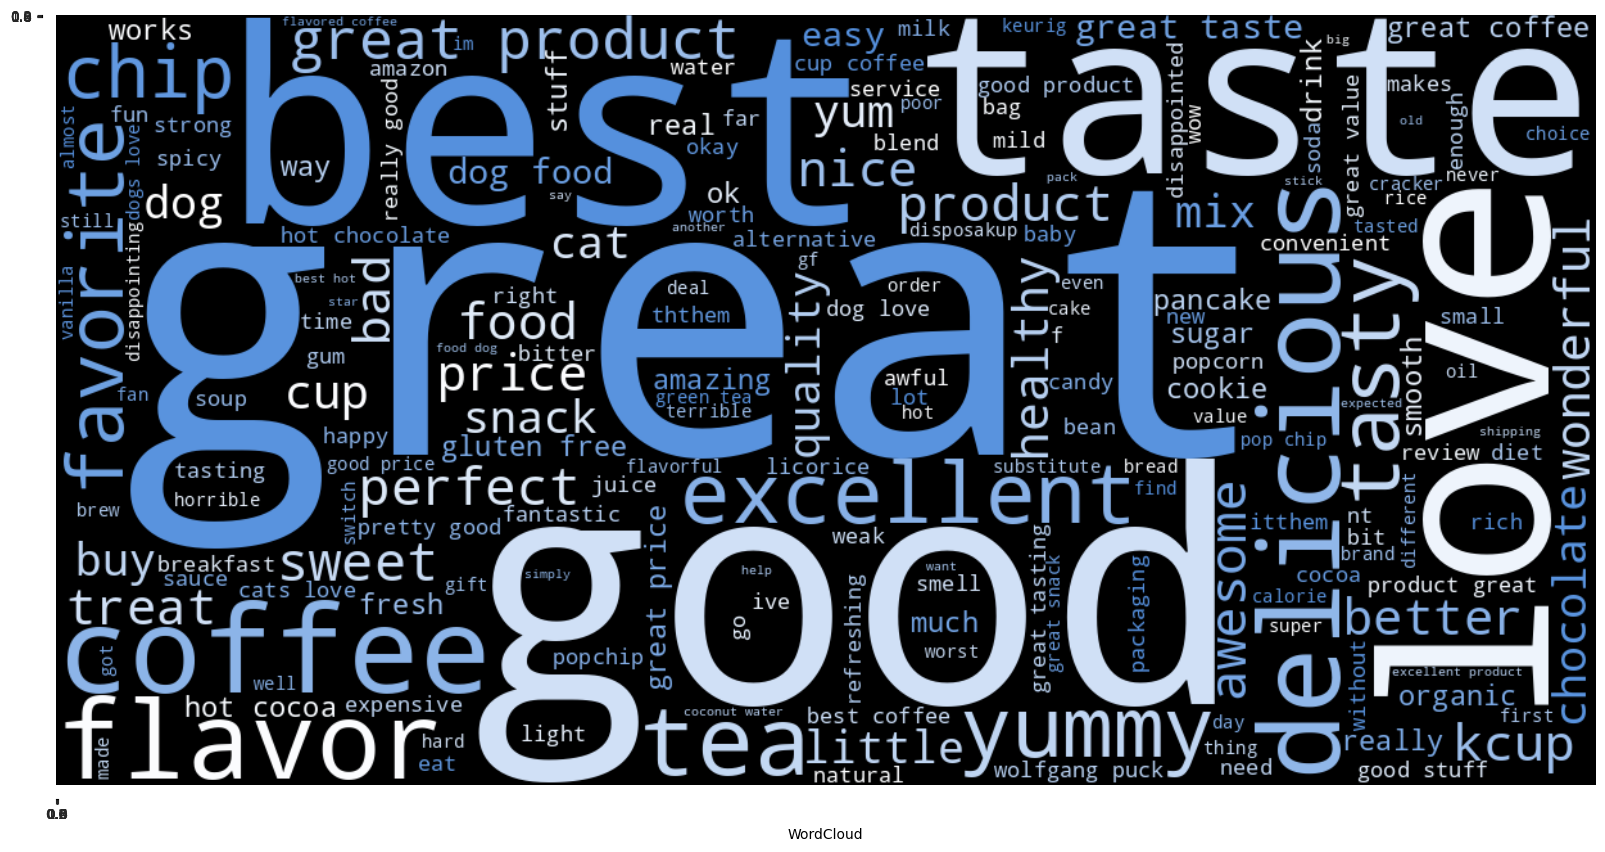

In [ ]:
plot_wordcloud(' '.join(df.headlines.values.tolist()), wc_blue_color_func)

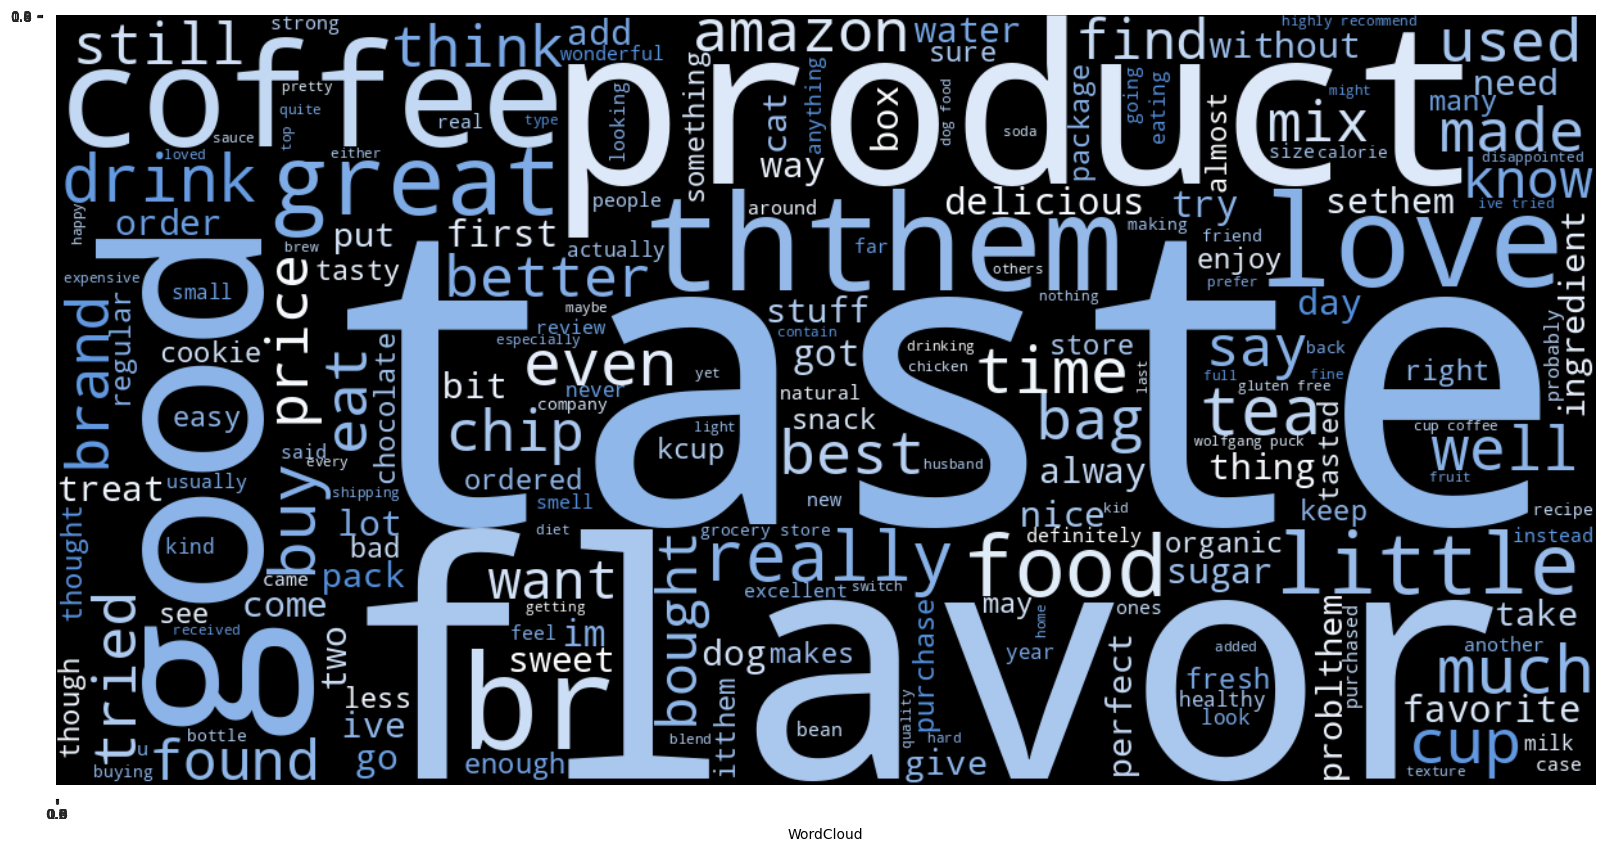

In [ ]:
plot_wordcloud(' '.join(df.text.values.tolist()), wc_blue_color_func)

Using a `start` and `end` tokens in `headlines(summary)` to let the learning algorithm know from where the headlines start's and end's.

In [ ]:
df.headlines = df.headlines.apply(lambda x: f'_START_ {x} _END_')

Again adding `tokens` ... but different ones.

In [ ]:
start_token = 'sostok'
end_token = 'eostok'
df.headlines = df.headlines.apply(lambda x: f'{start_token} {x} {end_token}')

It's important to use `sostok` and `eostok` as start and end tokens respectively as later while using `tensorflow's Tokenizer` will filter the tokens and covert them to lowercase.

**sostok** & **eostok** tokens are for us to know where to start & stop the summary because using `_START_` & `_END_`, tf's tokenizer with convert them to **start** & **end** respectively.

So while decoding the summary sequences of sentences like **'everything is going to end in 2012'** if use `_START_` & `_END_` tokens (which will make the sentence like **'start everything is going to end in 2012 end'** this) whome tf's tokenizer will convert to start and end then we will stop decoding as we hit first **end**, so this is bad and therefore **sostok** & **eostok** these tokens are used.

So we can just use these **sostok** & **eostok** instead of `_START_` & `_END_`, well you can but I tried both ways and while not using these `_START_` & `_END_` I was getting `undesired results` 🤯 😅 i.e. model's `results weren't good`.

In [ ]:
df.sample(5)

,headlines,text
324,sostok _START_ never arrived _END_ eostok,cancelled order cancelled without problthem po...
4401,sostok _START_ india tree superb _END_ eostok,india tree products great cannot beat value am...
9474,sostok _START_ yum _END_ eostok,great coffee mix godiva chocolate coffee regul...
3021,sostok _START_ good corral horse maybe additio...,love portable electric corrals fantastic optio...
6104,sostok _START_ awful _END_ eostok,know far worst tasting carrot juice ever think...


Finding what should be the `maximum length` of text and headlines that will be feed or accepted by the learning algorithm.

In [ ]:
# Remove rows with missing values in 'text' and 'headlines' columns
df.dropna(subset=['text', 'headlines'], inplace=True)


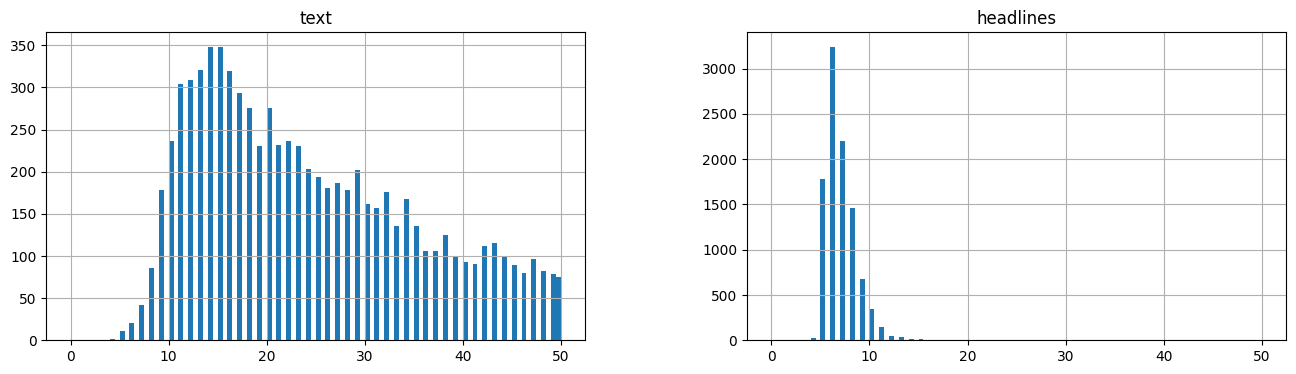

In [ ]:
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [ ]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-13 words
print(get_word_percent(df.headlines, 13))

# Check how many % of summary have 0-42 words
print(get_word_percent(df.text, 42))

1.0
0.71


If the length of headlines or the text is kept large the deep learning model will face issues with performance and also training will slower.

One solution for creating summary for long sentences can be break a paragraph into sentences and then create a summary for them, this way the summary will make sence instead of giving random piece of text and creating summary for it.

In [ ]:
max_text_len = 42
max_summary_len = 13

In [ ]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['text'])
    cleaned_summary = np.array(df['headlines'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 7093


,text,summary
3336,taking tea twice per day enjoying way feel,sostok _START_ great tea _END_ eostok
6310,general like walkers products tried avoid orde...,sostok _START_ cardboard _END_ eostok
4967,difficult judge amount grind coffee put kcups ...,sostok _START_ bad alittle pricey _END_ eostok
5653,roasted peeled chestnuts life since less time ...,sostok _START_ best chestnuts ever _END_ eostok
2774,several gevalia brand coffees among favorites ...,sostok _START_ wonderful smooth rich taste _EN...


In [ ]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

In [ ]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

**Tokenizing text 👉 x**

In [ ]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 70.85, 'total_coverage': 8.41, 'count': 8535, 'total_count': 12046}


🔥 to `increase computation speed` use this

```python
x_tokenizer = Tokenizer(num_words=x_tokens_data['total_count'] - x_tokens_data['count'])
```

In [ ]:
x_tokenizer = Tokenizer(num_words=x_tokens_data['total_count'] - x_tokens_data['count'])


In [ ]:
# else use this
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [ ]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

# else use this
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

12047


**Tokenizing headlines(summary) 👉 y**

In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 85.57, 'total_coverage': 10.63, 'count': 2715, 'total_count': 3173}


🔥 to `increase computation speed` use this

```python
y_tokenizer = Tokenizer(num_words=y_tokens_data['total_count'] - y_tokens_data['count'])
```

In [ ]:
y_tokenizer = Tokenizer(num_words=y_tokens_data['total_count'] - y_tokens_data['count'])


In [ ]:
# else use this
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [ ]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

3174


In [ ]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

## 🤼‍♂️ Modelling

![](https://media.giphy.com/media/YTJXDIivNMPuNSMgc0/giphy.gif)

In [ ]:
latent_dim = 240
embedding_dim = 300
num_epochs = 20

In [ ]:
%cd /content

In [ ]:
ls

In [ ]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = '/content/drive/MyDrive/glove.6B.300d.txt'

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 400000 word vectors.
Converted 8851 words (3195 misses)
Found 400000 word vectors.
Converted 2713 words (460 misses)


In [ ]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(12047, 300)
(3174, 300)


Using `pre-trained` embeddings and keeping the `Embedding` layer `non-trainable` we get increase in computation speed as don't need to compute the embedding matrix.

**Here there 3 different training models**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.
- `build_hybrid_seq2seq_model` - **Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

**Inference methods for the 3 different learning models - just add `_inference` as `prefix`**
- `build_seq2seq_model_with_just_lstm_inference`
- `build_seq2seq_model_with_bidirectional_lstm_inference`
- `build_hybrid_seq2seq_model_inference`

**Decoding sequence for the 3 different learning models - just add `decode_sequence_` as `suffix`**
- `decode_sequence_build_seq2seq_model_with_just_lstm`
- `decode_sequence_build_seq2seq_model_with_bidirectional_lstm`
- `decode_sequence_build_hybrid_seq2seq_model`

In [ ]:
import tensorflow as tf

try:
    # Resolver for TPU if available
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    # Initialize the TPU system and setup the strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default strategy that works on CPU and single GPU
    tpu_strategy = tf.distribute.get_strategy()

print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)


Number of accelerators:  1


**Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.

In [ ]:
def build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False
        )(encoder_input)

        # encoder lstm 1
        encoder_lstm1 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

        # encoder lstm 2
        encoder_lstm2 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=True
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        # decoder lstm 1
        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states
        )

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

**Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.

In [ ]:
def build_seq2seq_model_with_bidirectional_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False,
            name='encoder_embedding'
        )(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_1'
            ),
            name='encoder_bidirectional_lstm_1'
        )
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
            encoder_embedding
        )
        encoder_bi_lstm1_output = [
            encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
        ]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_2'
            ),
            name='encoder_bidirectional_lstm_2'
        )
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
            encoder_output1
        )
        encoder_bi_lstm2_output = [
            encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
        ]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_3'
            ),
            name='encoder_bidirectional_lstm_3'
        )
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=False,
            name='decoder_embedding'
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        decoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.2,
                name='decoder_lstm_1'
            ),
            name='decoder_bidirectional_lstm_1'
        )
        decoder_output, *decoder_final_states = decoder_bi_lstm(
            decoder_embedding, initial_state=encoder_final_states
            # decoder_embedding, initial_state=encoder_final_states[:2]
        )  # taking only the forward states

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_bi_lstm,
                    'dense': decoder_dense
                }
            }
        }

** **bold text**Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

In [ ]:
def build_hybrid_seq2seq_model(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False,
            name='encoder_embedding'
        )(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_1'
            ),
            name='encoder_bidirectional_lstm_1'
        )
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
            encoder_embedding
        )
        encoder_bi_lstm1_output = [
            encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
        ]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_2'
            ),
            name='encoder_bidirectional_lstm_2'
        )
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
            encoder_output1
        )
        encoder_bi_lstm2_output = [
            encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
        ]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_3'
            ),
            name='encoder_bidirectional_lstm_3'
        )
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=False,
            name='decoder_embedding'
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.2,
            name='decoder_lstm_1'
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states[:2]
        )  # taking only the forward states

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [ ]:
seq2seq = build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 42)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 42, 300)              3614100   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 42, 240),            519360    ['embedding[0][0]']           
                              (None, 240),                                                    

If you want to change `model` then just change the `function name` above.

In [ ]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [ ]:
model.layers[-2].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

Use a `tuple` instead of `list` in `validation_parameter` in `model.fit()`, to know the reason reading this [post](https://stackoverflow.com/questions/61586981/valueerror-layer-sequential-20-expects-1-inputs-but-it-received-2-input-tensor).

In [ ]:
import pickle
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

with open('model_history_seq2seq.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/20
50/50 [==============================] - 34s 399ms/step - loss: 2.8690 - accuracy: 0.6271 - val_loss: 1.6186 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 16s 323ms/step - loss: 1.6820 - accuracy: 0.7779 - val_loss: 1.3696 - val_accuracy: 0.8154 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 17s 342ms/step - loss: 1.5444 - accuracy: 0.7939 - val_loss: 1.3250 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 15s 308ms/step - loss: 1.5163 - accuracy: 0.7939 - val_loss: 1.3126 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 16s 322ms/step - loss: 1.5035 - accuracy: 0.7939 - val_loss: 1.3010 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 15s 303ms/step - loss: 1.4951 - accuracy: 0.7939 - val_loss: 1.2987 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 16s 324ms/st

In [ ]:
import pickle

# Save the history to a file
with open('model_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


In [ ]:
model.save('trained_model.h5')

**Plotting model's performance**

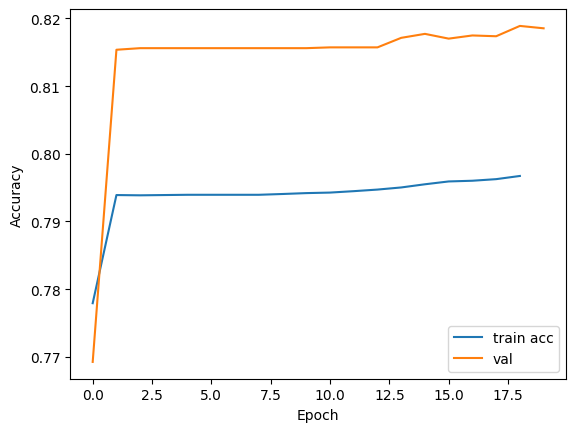

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

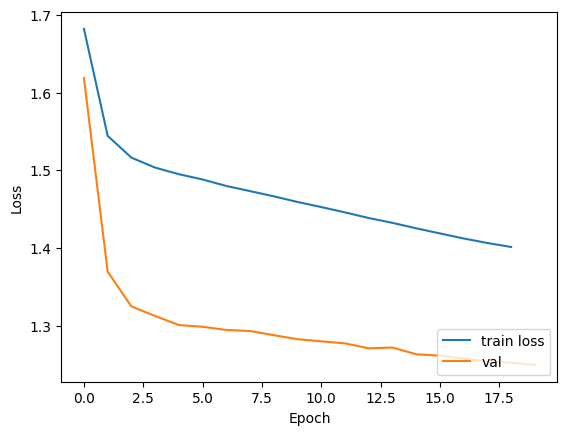

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## 🤸‍♂️ Inference

![](https://media.giphy.com/media/5FJcVeYFVysda/giphy.gif)

In [ ]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
def build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

Useful `stackoverflow` [post](https://stackoverflow.com/questions/60697843/tensorflow-keras-bidirectional-lstm-for-text-summarization) to understand `inference` process when using `bidirectional lstms` in `encoder` and `decoder` in the training model.

In [ ]:
def build_seq2seq_model_with_bidirectional_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):

    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [
        decoder_state_forward_input_h, decoder_state_forward_input_c,
        decoder_state_backward_input_h, decoder_state_backward_input_c
    ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
def build_hybrid_seq2seq_model_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):

    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [
        decoder_state_forward_input_h, decoder_state_forward_input_c,
        #decoder_state_backward_input_h, decoder_state_backward_input_c
    ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
encoder_model, decoder_model = build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42)]              0         
                                                                 
 embedding (Embedding)       (None, 42, 300)           3614100   
                                                                 
 lstm (LSTM)                 [(None, 42, 240),         519360    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 lstm_1 (LSTM)               [(None, 42, 240),         461760    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
Total params: 4595220 (17.53 MB)
Trainable params: 981120 (

In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, None, 300)            952200    ['input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 240)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 240)]                0         []                            
                                                                                            

In [ ]:
decoder_model.layers[-3].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

![](https://media.giphy.com/media/XKSa6XxpmHh1NEBvvl/giphy.gif)

Converting from `sequence to text` for model `with just LSTM's` and for model `with Bidirectional LSTM's`.

In [ ]:
def decode_sequence_seq2seq_model_with_just_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def decode_sequence_seq2seq_model_with_bidirectional_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict(
            [target_seq] + [e_out] + state_values
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [ ]:
def decode_sequence_hybrid_seq2seq_model(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict(
            [target_seq] + [e_out] + state_values[:2]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [ ]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [ ]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [ ]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if len(l) % 3 != 0:
    while len(l) % 3 != 0:
        l.append(0)
print(l)

lst_i = 3
for i in range(0, len(l), 3):
    print(l[i:i + lst_i])

print(' '.join(['', 'james', 'ethan', '', 'tony']))
print(' '.join(' '.join(['', 'james', 'ethan', '', 'tony']).split()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0]
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 0, 0]
 james ethan  tony
james ethan tony


For predicting `unseen` data pass `decode_sequence` function for which you want to decode.

In [ ]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text([text])  # generator
    text_list = original_text.split()

    if len(text_list) <= max_text_len:
        text = expand_contractions(text)
        text = clean_text(text)
        text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(
            padded.reshape(1, max_text_len), encoder_model, decoder_model
        )
        return pred_summary
    else:
        pred_summary = ''

        # breaking long texts to individual max_text_len texts and predicting on them
        while len(text_list) % max_text_len == 0:
            text_list.append('')

        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(
                _text.split()
            )  # to remove spaces that were added to make len(text_list) % max_text_len == 0

            _text = expand_contractions(_text)
            _text = clean_text(_text)  # generator
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'
            # print(_text, '\n')

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(
                _padded.reshape(1, max_text_len), encoder_model, decoder_model
            )
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary

## 🔮 Predictions

![](https://media.giphy.com/media/1wqqlaQ7IX3TXibXZE/giphy.gif)

In [ ]:
# Testing on training data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  daves nuts fantastic hot spicy crunchy habitformingbr br babies frail women wimpy men need order 
Original summary:  start wimps end 
1/1 [==============================] - 0s 19ms/step
Predicted summary:   start great end

# 2 News:  bought yes come plastic bags label also included five sided box fold together picture flavor one side makes cute little colorful box nice give gift put together 
Original summary:  start cute packaging put together end 
1/1 [==============================] - 0s 20ms/step
Predicted summary:   start great end

# 3 News:  found tea accident worked well later ordered itbr br able find really helps open nasal passagesbr br since starting use whenever bad nasal congestion notbr br sinus infection everyone different sure worked 
Original summary:  start sinus help end 
1/1 [==============================] - 0s 20ms/step
Predicted summary:   start great end

# 4 News:  favorite coffee blending hazelnut coconut perfect thank youbr br question charged po

In [ ]:
# Testing on validation data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_val_padded[i]))
    print("Original summary: ", seq2summary(y_val_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_val_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  reading reviews got nervous opened bag recent order expecting worst worries bags great shape expiration dates chips least first bag taste like supposed good world way bags thirty dollars ton less expensive going price around local grocery store yay team 
Original summary:  start favorite kettle flavor great value end 
1/1 [==============================] - 0s 18ms/step
Predicted summary:   start great product end

# 2 News:  truly enjoy good cup coffee give lift morning wolfgang puck really knows produce fine cup thanks 
Original summary:  start great cup coffee end 
1/1 [==============================] - 0s 20ms/step
Predicted summary:   start great end

# 3 News:  like cracker good little fill meals 
Original summary:  start good snack end 
1/1 [==============================] - 0s 19ms/step
Predicted summary:   start great end

# 4 News:  friend brought argentina kids ate spoon apples would feel less guilty finished immediately panicked sure could get us low behold found 

## 🎁 Saving the model

In [ ]:
# HDF5 format
model.save('model.h5')
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

## 🏌️‍♂️ Running all the 3 different models

After understanding how all the pieces work, running all the `3 models` to understand how it `performs` and its `results`.

**Here there 3 different training models**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.
- `build_hybrid_seq2seq_model` - **Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

**Inference methods for the 3 different learning models - just add `_inference` as `prefix`**
- `build_seq2seq_model_with_just_lstm_inference`
- `build_seq2seq_model_with_bidirectional_lstm_inference`
- `build_hybrid_seq2seq_model_inference`

**Decoding sequence for the 3 different learning models - just add `decode_sequence_` as `suffix`**
- `decode_sequence_build_seq2seq_model_with_just_lstm`
- `decode_sequence_build_seq2seq_model_with_bidirectional_lstm`
- `decode_sequence_build_hybrid_seq2seq_model`

![](https://media.giphy.com/media/3ogmaPGsQOruw/giphy.gif)

In [ ]:
models_info = {
    'just_lstm': {
        'model': build_seq2seq_model_with_just_lstm,
        'inference': build_seq2seq_model_with_just_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_just_lstm
    },
    'bidirectional_lstm': {
        'model': build_seq2seq_model_with_bidirectional_lstm,
        'inference': build_seq2seq_model_with_bidirectional_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_bidirectional_lstm
    },
    'hybrid_model': {
        'model': build_hybrid_seq2seq_model,
        'inference': build_hybrid_seq2seq_model_inference,
        'decode_sequence': decode_sequence_hybrid_seq2seq_model
    }
}

**Model with just LSTMs**

In [ ]:
model_func = models_info['just_lstm']['model']
inference_func = models_info['just_lstm']['inference']
decode_sequence_func = models_info['just_lstm']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 42)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 42, 300)              3614100   ['input_6[0][0]']             
                                                                                                  
 input_7 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 lstm_3 (LSTM)               [(None, 42, 240),            519360    ['embedding_2[0][0]']         
                              (None, 240),                                                  

In [ ]:
import pickle

history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

# Save the history to a file
with open('model_history_with_just_lstm.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/20
50/50 [==============================] - 26s 366ms/step - loss: 2.8936 - accuracy: 0.6295 - val_loss: 1.6426 - val_accuracy: 0.7901 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 16s 325ms/step - loss: 1.6814 - accuracy: 0.7773 - val_loss: 1.3565 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 15s 306ms/step - loss: 1.5436 - accuracy: 0.7939 - val_loss: 1.3195 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 15s 306ms/step - loss: 1.5154 - accuracy: 0.7939 - val_loss: 1.3076 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 15s 305ms/step - loss: 1.5020 - accuracy: 0.7939 - val_loss: 1.3047 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 15s 309ms/step - loss: 1.4929 - accuracy: 0.7940 - val_loss: 1.2989 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 16s 326ms/st

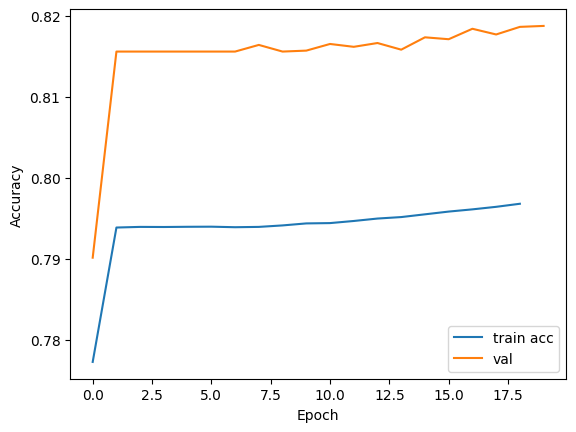

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

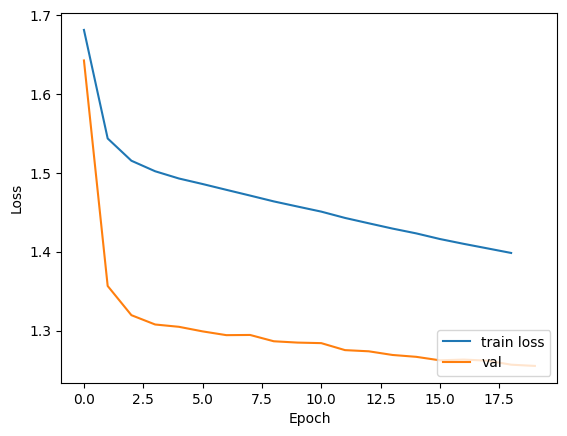

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

In [ ]:
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, None, 300)            952200    ['input_7[0][0]']             
                                                                                                  
 input_8 (InputLayer)        [(None, 240)]                0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 240)]                0         []                            
                                                                                            

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

**Model with Bidirectional LSTMs**

In [ ]:
model_func = models_info['bidirectional_lstm']['model']
inference_func = models_info['bidirectional_lstm']['inference']
decode_sequence_func = models_info['bidirectional_lstm']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 42)]                 0         []                            
                                                                                                  
 encoder_embedding (Embeddi  (None, 42, 300)              3614100   ['input_11[0][0]']            
 ng)                                                                                              
                                                                                                  
 encoder_bidirectional_lstm  [(None, 42, 480),            1038720   ['encoder_embedding[0][0]']   
 _1 (Bidirectional)           (None, 240),                                                        
                              (None, 240),                    

In [ ]:
import pickle
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

with open('model_history_bidirect.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/20
50/50 [==============================] - 65s 852ms/step - loss: 2.4587 - accuracy: 0.6981 - val_loss: 1.3289 - val_accuracy: 0.8131 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 42s 843ms/step - loss: 1.4424 - accuracy: 0.7955 - val_loss: 1.1705 - val_accuracy: 0.8259 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 44s 877ms/step - loss: 1.3307 - accuracy: 0.8044 - val_loss: 1.0792 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 45s 911ms/step - loss: 1.2440 - accuracy: 0.8214 - val_loss: 1.0023 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 42s 841ms/step - loss: 1.1595 - accuracy: 0.8347 - val_loss: 0.9310 - val_accuracy: 0.8668 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 41s 827ms/step - loss: 1.0843 - accuracy: 0.8442 - val_loss: 0.8703 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 41s 822ms/st

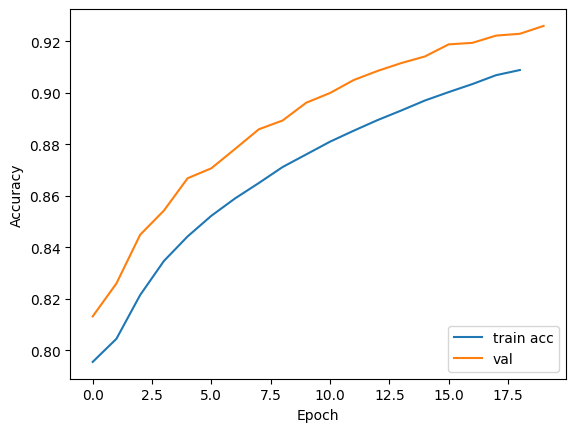

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

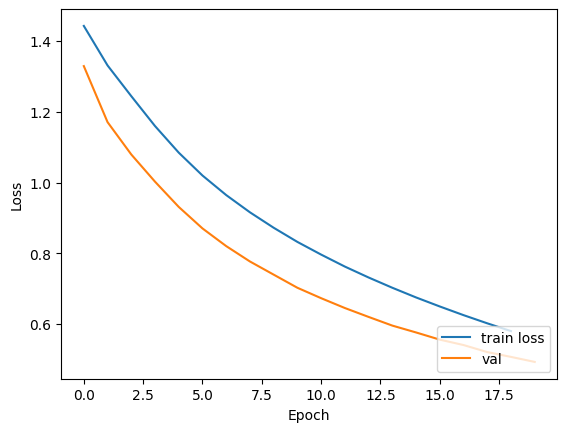

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 42)]              0         
                                                                 
 encoder_embedding (Embeddi  (None, 42, 300)           3614100   
 ng)                                                             
                                                                 
 encoder_bidirectional_lstm  [(None, 42, 480),         1038720   
 _1 (Bidirectional)           (None, 240),                       
                              (None, 240),                       
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 encoder_bidirectional_lstm  [(None, 42, 480),         1384320   
 _2 (Bidirectional)           (None, 240),                 

In [ ]:
decoder_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 decoder_embedding (Embeddi  (None, None, 300)            952200    ['input_12[0][0]']            
 ng)                                                                                              
                                                                                                  
 input_13 (InputLayer)       [(None, 240)]                0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 240)]                0         []                      

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  daves nuts fantastic hot spicy crunchy habitformingbr br babies frail women wimpy men need order 
Original summary:  start wimps end 
1/1 [==============================] - 0s 22ms/step
Predicted summary:   end start start start start start start start start start start start

# 2 News:  bought yes come plastic bags label also included five sided box fold together picture flavor one side makes cute little colorful box nice give gift put together 
Original summary:  start cute packaging put together end 
1/1 [==============================] - 0s 20ms/step
Predicted summary:   end start start start start start start start start start start start

# 3 News:  found tea accident worked well later ordered itbr br able find really helps open nasal passagesbr br since starting use whenever bad nasal congestion notbr br sinus infection everyone different sure worked 
Original summary:  start sinus help end 
1/1 [==============================] - 0s 21ms/step
Predicted summary:   end 

### Model with hybrid architecture

In [ ]:
model_func = models_info['hybrid_model']['model']
inference_func = models_info['hybrid_model']['inference']
decode_sequence_func = models_info['hybrid_model']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 42)]                 0         []                            
                                                                                                  
 encoder_embedding (Embeddi  (None, 42, 300)              3614100   ['input_18[0][0]']            
 ng)                                                                                              
                                                                                                  
 encoder_bidirectional_lstm  [(None, 42, 480),            1038720   ['encoder_embedding[0][0]']   
 _1 (Bidirectional)           (None, 240),                                                        
                              (None, 240),                    

In [ ]:
import pickle

history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/20


50/50 [==============================] - 53s 700ms/step - loss: 2.8731 - accuracy: 0.6278 - val_loss: 1.6292 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 35s 708ms/step - loss: 1.6955 - accuracy: 0.7711 - val_loss: 1.3640 - val_accuracy: 0.8148 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 34s 690ms/step - loss: 1.5470 - accuracy: 0.7935 - val_loss: 1.3244 - val_accuracy: 0.8155 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 34s 672ms/step - loss: 1.5166 - accuracy: 0.7937 - val_loss: 1.3103 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 35s 701ms/step - loss: 1.5031 - accuracy: 0.7939 - val_loss: 1.3075 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 34s 676ms/step - loss: 1.4937 - accuracy: 0.7938 - val_loss: 1.2982 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 34s 688ms/step - loss: 

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

In [ ]:
decoder_model.summary()

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

---

I'll wrap things up there. If you want to find some other answers then go ahead `edit` this kernel. If you have any `questions` then do let me know.

If this kernel helped you then don't forget to 🔼 `upvote` and share your 🎙 `feedback` on improvements of the kernel.

![](https://media.giphy.com/media/3o85xAYQLOhSrmINHO/giphy.gif)

---